In [1]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

# Load mock and data into memory

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

import os
dirname = "/Volumes/simulation_data_2018/protoDC2_v4"
basename_z0p00 = "umachine_color_mock_v4_m000-499.hdf5"
basename_z0p25 = "umachine_color_mock_v4_m000-392.hdf5"
basename_z0p50 = "umachine_color_mock_v4_m000-331.hdf5"
basename_z0p75 = "umachine_color_mock_v4_m000-286.hdf5"
basename_z1p00 = "umachine_color_mock_v4_m000-253.hdf5"

redshift = 0.0
if redshift == 0.0:
    basename = basename_z0p00
elif redshift == 0.25:
    basename = basename_z0p25
elif redshift == 0.5:
    basename = basename_z0p50
elif redshift == 0.75:
    basename = basename_z0p75
elif redshift == 1.0:
    basename = basename_z1p00


Lbox = 256.
Lbox_physical = Lbox/(1. + redshift)
Veff = Lbox_physical**3.


fname = os.path.join(dirname, basename)

from astropy.table import Table
mock = Table.read(fname, path='data')
mock['redshift'] = redshift
mock.rename_column('restframe_extincted_sdss_abs_magr', 'um_mag_r_rest')
mock.rename_column('restframe_extincted_sdss_gr', 'um_gr_rest')
mock.rename_column('restframe_extincted_sdss_ri', 'um_ri_rest')
mock['um_mag_g_rest'] = mock['um_gr_rest'] + mock['um_mag_r_rest']

print(mock.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']
['source_halo_id', 'target_halo_id', 'target_halo_x', 'target_halo_y', 'target_halo_z', 'target_halo_vx', 'target_halo_vy', 'target_halo_vz', 'target_halo_mass', 'host_halo_mvir', 'upid', 'mpeak', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sm', 'obs_sfr', 'sfr_percentile', 'um_mag_r_rest', 'um_gr_rest', 'um_ri_rest', 'is_on_red_sequence_gr', 'is_on_red_sequence_ri', 'x', 'vx', 'y', 'vy', 'z', 'vz', 'lightcone_id', 'redshift', 'um_mag_g_rest']


In [3]:
logsm_cut = 8
mock = mock[mock['obs_sm'] > 10**logsm_cut]

# Remodel rest-frame $M_{\rm g}, M_{\rm i}, M_{\rm i},$ and also $M_{\ast}$ at high-mass 

### Model $M_{\ast}$ and $M_{\rm r}$

In [4]:
# from cosmodc2.stellar_mass_remapping import lift_high_mass_mstar

# mock['new_mstar'] = lift_high_mass_mstar(
#         mock['mpeak'], mock['obs_sm'], mock['upid'], mock['redshift'])

# from cosmodc2.sdss_colors import magr_monte_carlo

# mock['new_um_mag_r_rest'] = magr_monte_carlo(
#     mock['new_mstar'], mock['redshift'], mock['upid'])

# mock['new2_um_mag_r_rest'] = mock['new_um_mag_r_rest']

In [5]:
from cosmodc2.stellar_mass_remapping import lift_high_mass_mstar

new_mstar = lift_high_mass_mstar(
        mock['mpeak'], mock['obs_sm'], mock['upid'],  mock['redshift'])
mock['new_mstar'] = new_mstar
    
from cosmodc2.sdss_colors import magr_monte_carlo
mock['new_um_mag_r_rest'] = magr_monte_carlo(
    mock['new_mstar'], mock['upid'], mock['redshift'])
mock['new2_um_mag_r_rest'] = magr_monte_carlo(
    mock['new_mstar'], mock['upid'], mock['redshift'], beta_z0_satellites=2.85)


### Model ${\rm g-r}$ and ${\rm r-i}$

In [6]:
from cosmodc2.sdss_colors import gr_ri_monte_carlo

gr_mock, ri_mock, is_red_ri_mock, is_red_gr_mock = gr_ri_monte_carlo(
    mock['new_um_mag_r_rest'], mock['sfr_percentile'], 
    mock['redshift'], local_random_scale=0.1)

mock['new_um_gr_rest'] = np.copy(gr_mock)
mock['new_um_ri_rest'] = np.copy(ri_mock)

mock['is_on_red_sequence_gr'] = is_red_gr_mock
mock['is_on_red_sequence_ri'] = is_red_ri_mock


In [7]:
from cosmodc2.sdss_colors import gr_ri_monte_carlo

gr_mock2, ri_mock2, is_red_ri_mock, is_red_gr_mock = gr_ri_monte_carlo(
    mock['new2_um_mag_r_rest'], mock['sfr_percentile'], 
    mock['redshift'], local_random_scale=0.1)

mock['new2_um_gr_rest'] = np.copy(gr_mock2)
mock['new2_um_ri_rest'] = np.copy(ri_mock2)


### Model cluster centrals

In [8]:
from cosmodc2.sdss_colors import remap_cluster_bcg_gr_ri_color

_result = remap_cluster_bcg_gr_ri_color(
        mock['upid'], mock['host_halo_mvir'],
        np.copy(mock['new_um_gr_rest']), np.copy(mock['new_um_ri_rest']), 
        mock['is_on_red_sequence_gr'], mock['is_on_red_sequence_ri'])
gr_mock, ri_mock, is_red_gr_mock, is_red_ri_mock = _result

mock['new_um_gr_rest'] = gr_mock
mock['new_um_ri_rest'] = ri_mock
mock['is_on_red_sequence_gr'] = is_red_gr_mock
mock['is_on_red_sequence_ri'] = is_red_ri_mock

In [9]:
from cosmodc2.sdss_colors import remap_cluster_bcg_gr_ri_color

_result = remap_cluster_bcg_gr_ri_color(
        mock['upid'], mock['host_halo_mvir'],
        np.copy(mock['new2_um_gr_rest']), np.copy(mock['new2_um_ri_rest']), 
        mock['is_on_red_sequence_gr'], mock['is_on_red_sequence_ri'],
        prob_remap_table=(0, 0.5, 0.75, 1))
gr_mock2, ri_mock2, __, __ = _result

mock['new2_um_gr_rest'] = gr_mock2
mock['new2_um_ri_rest'] = ri_mock2

# mock['new2_um_gr_rest'] = gr_mock
# mock['new2_um_ri_rest'] = ri_mock


In [10]:
# fig, ax = plt.subplots(1, 1)

# magr_mask = mock['new_um_mag_r_rest'] < -19
# satmask = mock['upid'] != -1
# cluster_mask = mock['host_halo_mvir'] > 10**14
# red_sequence_mask = mock['is_on_red_sequence_gr'] == True

# gr_bins = np.linspace(0, 1.25, 50)
# __=ax.hist(mock['new_um_gr_rest'][cluster_mask & ~satmask & magr_mask], 
#           bins=gr_bins, normed=True, alpha=0.8, color=morange)

# __=ax.hist(mock['new2_um_gr_rest'][cluster_mask & ~satmask & magr_mask], 
#           bins=gr_bins, normed=True, alpha=0.8, color=mblue)

# ri_bins = np.linspace(0., 0.75, 50)

# __=ax.hist(mock['new_um_ri_rest'][cluster_mask & ~satmask & magr_mask], 
#           bins=ri_bins, normed=True, alpha=0.8, color=morange)

# __=ax.hist(mock['new2_um_ri_rest'][cluster_mask & ~satmask & magr_mask], 
#           bins=ri_bins, normed=True, alpha=0.8, color=mblue)

# __=ax.hist(mock['new_um_ri_rest'][red_sequence_mask & magr_mask], 
#           bins=ri_bins, normed=True, alpha=0.8, color=morange)

# __=ax.hist(mock['new2_um_ri_rest'][red_sequence_mask & magr_mask], 
#           bins=ri_bins, normed=True, alpha=0.8, color=mblue)


# group_halo_mask = mock['host_halo_mvir'] > 10**13.5

# __=ax.hist(mock['new_um_ri_rest'][group_halo_mask & ~satmask & magr_mask], 
#           bins=ri_bins, normed=True, alpha=0.8, color=morange)

# __=ax.hist(mock['new2_um_ri_rest'][group_halo_mask & ~satmask & magr_mask], 
#           bins=ri_bins, normed=True, alpha=0.8, color=mblue)

# xlim = ax.set_xlim(0, 0.75)

### Model cluster satellites

In [11]:
from cosmodc2.sdss_colors import remap_cluster_satellite_gr_ri_color

_result = remap_cluster_satellite_gr_ri_color(
        mock['upid'], mock['new_mstar'], mock['host_halo_mvir'], 
        mock['new_um_mag_r_rest'], np.copy(mock['new_um_gr_rest']), 
        np.copy(mock['new_um_ri_rest']),
        mock['is_on_red_sequence_gr'], mock['is_on_red_sequence_ri'])

gr_mock, ri_mock, is_red_gr_mock, is_red_ri_mock = _result

mock['new_um_gr_rest'] = gr_mock
mock['new_um_ri_rest'] = ri_mock
mock['is_on_red_sequence_gr'] = is_red_gr_mock
mock['is_on_red_sequence_ri'] = is_red_ri_mock

In [12]:
from cosmodc2.sdss_colors import remap_cluster_satellite_gr_ri_color

_result = remap_cluster_satellite_gr_ri_color(
        mock['upid'], mock['new_mstar'], mock['host_halo_mvir'], 
        mock['new2_um_mag_r_rest'], np.copy(mock['new2_um_gr_rest']), 
        np.copy(mock['new2_um_ri_rest']),
        mock['is_on_red_sequence_gr'], mock['is_on_red_sequence_ri'])

gr_mock2, ri_mock2, __, __ = _result

mock['new2_um_gr_rest'] = gr_mock2
mock['new2_um_ri_rest'] = ri_mock2


## Compare one-point functions to SDSS color distributions

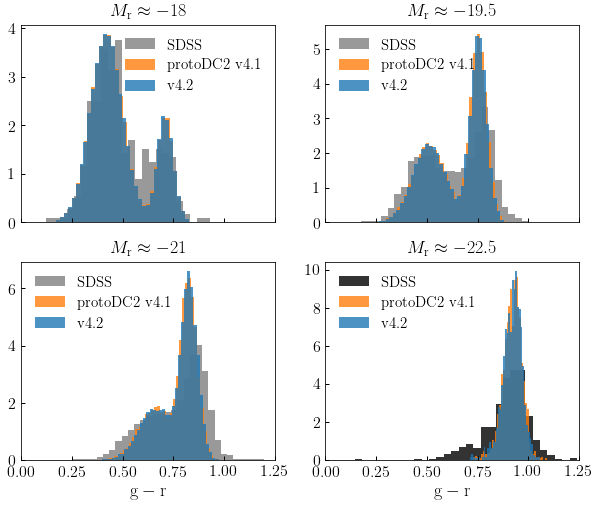

In [13]:
npts = int(1e6)

from cosmodc2.sdss_colors.sdss_completeness_model import retrieve_sdss_sample_mask

magr_max = -18.
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_gr18 = sdss['restframe_extincted_sdss_gr'][mask]
mock_mask = (mock['new_um_mag_r_rest'] < magr_max)
mock_mask *= (mock['new_um_mag_r_rest'] > magr_min)
mock_sample_gr18 = mock['new_um_gr_rest'][mock_mask]
mock_sample_gr18_alt = mock['new2_um_gr_rest'][mock_mask]

magr_max = -19.5
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_gr19p5 = sdss['restframe_extincted_sdss_gr'][mask]
mock_mask = (mock['new_um_mag_r_rest'] < magr_max)
mock_mask *= (mock['new_um_mag_r_rest'] > magr_min)
mock_sample_gr19p5 = mock['new_um_gr_rest'][mock_mask]
mock_sample_gr19p5_alt = mock['new2_um_gr_rest'][mock_mask]

magr_max = -21.
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_gr21 = sdss['restframe_extincted_sdss_gr'][mask]
mock_mask = (mock['new_um_mag_r_rest'] < magr_max)
mock_mask *= (mock['new_um_mag_r_rest'] > magr_min)
mock_sample_gr21 = mock['new_um_gr_rest'][mock_mask]
mock_sample_gr21_alt = mock['new2_um_gr_rest'][mock_mask]

magr_max = -22.5
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_gr22p5 = sdss['restframe_extincted_sdss_gr'][mask]
mock_mask = (mock['new_um_mag_r_rest'] < magr_max)
mock_mask *= (mock['new_um_mag_r_rest'] > magr_min)
mock_sample_gr22p5 = mock['new_um_gr_rest'][mock_mask]
mock_sample_gr22p5_alt = mock['new2_um_gr_rest'][mock_mask]


fig, _axes = plt.subplots(2, 2, figsize=(10, 8))

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4

nbins = 40

__=ax1.hist(sdss_sample_gr18, bins=nbins, alpha=0.8, normed=True, 
            label=r'${\rm SDSS}$', color='gray')
__=ax1.hist(mock_sample_gr18, bins=nbins, alpha=0.8, normed=True, 
            color=morange, label=r'${\rm protoDC2\ v4.1}$')
__=ax1.hist(mock_sample_gr18_alt, bins=nbins, alpha=0.8, normed=True, 
            color=mblue, label=r'${\rm v4.2}$')

__=ax2.hist(sdss_sample_gr19p5, bins=nbins, alpha=0.8, normed=True, 
            label=r'${\rm SDSS}$', color='gray')
__=ax2.hist(mock_sample_gr19p5, bins=nbins, alpha=0.8, normed=True, 
            color=morange, label=r'${\rm protoDC2\ v4.1}$')
__=ax2.hist(mock_sample_gr19p5_alt, bins=nbins, alpha=0.8, normed=True, 
            color=mblue, label=r'${\rm v4.2}$')

__=ax3.hist(sdss_sample_gr21, bins=nbins, alpha=0.8, normed=True, 
            label=r'${\rm SDSS}$', color='gray')
__=ax3.hist(mock_sample_gr21, bins=nbins, alpha=0.8, normed=True, 
            color=morange, label=r'${\rm protoDC2\ v4.1}$')
__=ax3.hist(mock_sample_gr21_alt, bins=nbins, alpha=0.8, normed=True, 
            color=mblue, label=r'${\rm v4.2}$')

__=ax4.hist(sdss_sample_gr22p5, bins=nbins, alpha=0.8, normed=True, 
            label=r'${\rm SDSS}$', color='k')
__=ax4.hist(mock_sample_gr22p5, bins=nbins, alpha=0.8, normed=True, 
            color=morange, label=r'${\rm protoDC2\ v4.1}$')
__=ax4.hist(mock_sample_gr22p5_alt, bins=nbins, alpha=0.8, normed=True, 
            color=mblue, label=r'${\rm v4.2}$')

for ax in axes:
    xlim = ax.set_xlim(0, 1.25)
    leg = ax.legend()

ax1.set_xticklabels([''])
ax2.set_xticklabels([''])
title1 = ax1.set_title(r'$M_{\rm r} \approx -18$')
title2 = ax2.set_title(r'$M_{\rm r} \approx -19.5$')
title3 = ax3.set_title(r'$M_{\rm r} \approx -21$')
title4 = ax4.set_title(r'$M_{\rm r} \approx -22.5$')
xlabel3 = ax3.set_xlabel(r'${\rm g-r}$')
xlabel4 = ax4.set_xlabel(r'${\rm g-r}$')


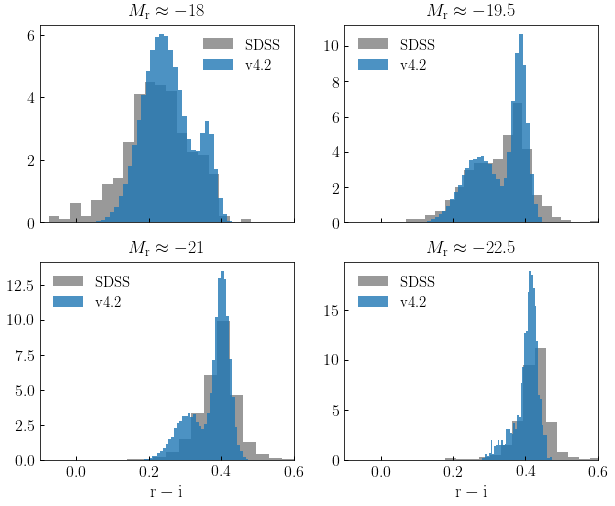

In [14]:
npts = int(1e6)

from cosmodc2.sdss_colors.sdss_completeness_model import retrieve_sdss_sample_mask

magr_max = -18.
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_ri18 = sdss['restframe_extincted_sdss_ri'][mask]
mock_mask = (mock['new_um_mag_r_rest'] < magr_max)
mock_mask *= (mock['new_um_mag_r_rest'] > magr_min)
mock_sample_ri18 = mock['new_um_ri_rest'][mock_mask]
mock_sample_ri18_alt = mock['new2_um_ri_rest'][mock_mask]

magr_max = -19.5
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_ri19p5 = sdss['restframe_extincted_sdss_ri'][mask]
mock_mask = (mock['new_um_mag_r_rest'] < magr_max)
mock_mask *= (mock['new_um_mag_r_rest'] > magr_min)
mock_sample_ri19p5 = mock['new_um_ri_rest'][mock_mask]
mock_sample_ri19p5_alt = mock['new2_um_ri_rest'][mock_mask]

magr_max = -21.
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_ri21 = sdss['restframe_extincted_sdss_ri'][mask]
mock_mask = (mock['new_um_mag_r_rest'] < magr_max)
mock_mask *= (mock['new_um_mag_r_rest'] > magr_min)
mock_sample_ri21 = mock['new_um_ri_rest'][mock_mask]
mock_sample_ri21_alt = mock['new2_um_ri_rest'][mock_mask]

magr_max = -22.5
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_ri22p5 = sdss['restframe_extincted_sdss_ri'][mask]
mock_mask = (mock['new_um_mag_r_rest'] < magr_max)
mock_mask *= (mock['new_um_mag_r_rest'] > magr_min)
mock_sample_ri22p5 = mock['new_um_ri_rest'][mock_mask]
mock_sample_ri22p5_alt = mock['new2_um_ri_rest'][mock_mask]


fig, _axes = plt.subplots(2, 2, figsize=(10, 8))

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4

nbins = 40

__=ax1.hist(sdss_sample_ri18, bins=nbins, alpha=0.8, normed=True, 
            label=r'${\rm SDSS}$', color='gray')
# __=ax1.hist(mock_sample_ri18, bins=nbins, alpha=0.8, normed=True, 
#             color=morange, label=r'${\rm v4.1}$')
__=ax1.hist(mock_sample_ri18_alt, bins=nbins, alpha=0.8, normed=True, 
            color=mblue, label=r'${\rm v4.2}$')

__=ax2.hist(sdss_sample_ri19p5, bins=nbins, alpha=0.8, normed=True, 
            label=r'${\rm SDSS}$', color='gray')
# __=ax2.hist(mock_sample_ri19p5, bins=nbins, alpha=0.8, normed=True, 
#             color=morange, label=r'${\rm v4.1}$')
__=ax2.hist(mock_sample_ri19p5_alt, bins=nbins, alpha=0.8, normed=True, 
            color=mblue, label=r'${\rm v4.2}$')

__=ax3.hist(sdss_sample_ri21, bins=nbins, alpha=0.8, normed=True, 
            label=r'${\rm SDSS}$', color='gray')
# __=ax3.hist(mock_sample_ri21, bins=nbins, alpha=0.8, normed=True, 
#             color=morange, label=r'${\rm v4.1}$')
__=ax3.hist(mock_sample_ri21_alt, bins=nbins, alpha=0.8, normed=True, 
            color=mblue, label=r'${\rm v4.2}$')

__=ax4.hist(sdss_sample_ri22p5, bins=nbins, alpha=0.8, normed=True, 
            label=r'${\rm SDSS}$', color='gray')
# __=ax4.hist(mock_sample_ri22p5, bins=nbins, alpha=0.8, normed=True, 
#             color=morange, label=r'${\rm v4.1}$')
__=ax4.hist(mock_sample_ri22p5_alt, bins=nbins, alpha=0.8, normed=True, 
            color=mblue, label=r'${\rm v4.2}$')

for ax in axes:
    xlim = ax.set_xlim(-0.1, 0.6)
    leg = ax.legend()

ax1.set_xticklabels([''])
ax2.set_xticklabels([''])
title1 = ax1.set_title(r'$M_{\rm r} \approx -18$')
title2 = ax2.set_title(r'$M_{\rm r} \approx -19.5$')
title3 = ax3.set_title(r'$M_{\rm r} \approx -21$')
title4 = ax4.set_title(r'$M_{\rm r} \approx -22.5$')
xlabel3 = ax3.set_xlabel(r'${\rm r-i}$')
xlabel4 = ax4.set_xlabel(r'${\rm r-i}$')


## Compare color-dependent clustering to Zehavi+11

In [15]:
from cosmodc2.sdss_colors import zehavi11_clustering
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi


In [16]:
wp_blue19p0, wperr_blue19p0 = zehavi11_clustering(-19, subsample='blue')
wp_red19p0, wperr_red19p0 = zehavi11_clustering(-19, subsample='red')

wp_blue20p0, wperr_blue20p0 = zehavi11_clustering(-20, subsample='blue')
wp_red20p0, wperr_red20p0 = zehavi11_clustering(-20, subsample='red')

wp_blue20p5, wperr_blue20p5 = zehavi11_clustering(-20.5, subsample='blue')
wp_red20p5, wperr_red20p5 = zehavi11_clustering(-20.5, subsample='red')

wp_blue21p0, wperr_blue21p0 = zehavi11_clustering(-21, subsample='blue')
wp_red21p0, wperr_red21p0 = zehavi11_clustering(-21, subsample='red')

wp_blue21p5, wperr_blue21p5 = zehavi11_clustering(-21.5, subsample='blue')
wp_red21p5, wperr_red21p5 = zehavi11_clustering(-21.5, subsample='red')


In [17]:
from cosmodc2.mock_diagnostics import zehavi_wp

protoDC2_littleh = 0.7
period = Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['new_um_mag_r_rest']

rp_mids, wp_v4_20p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -20.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['new_um_gr_rest'])

rp_mids, wp_v4_20p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -20.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['new_um_gr_rest'])

rp_mids, wp_v4_19p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['new_um_gr_rest'])

rp_mids, wp_v4_19p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['new_um_gr_rest'])

rp_mids, wp_v4_20p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['new_um_gr_rest'])

rp_mids, wp_v4_20p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['new_um_gr_rest'])

rp_mids, wp_v4_21p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -21.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['new_um_gr_rest'])

rp_mids, wp_v4_21p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -21.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['new_um_gr_rest'])

rp_mids, wp_v4_21p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['new_um_gr_rest'])

rp_mids, wp_v4_21p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['new_um_gr_rest'])

...calculating wp for 5.71e+04 galaxies and Mr < -20.0
...calculating wp for 4.68e+04 galaxies and Mr < -20.0
...calculating wp for 1.00e+05 galaxies and Mr < -19.0
...calculating wp for 8.09e+04 galaxies and Mr < -19.0
...calculating wp for 2.17e+04 galaxies and Mr < -20.5
...calculating wp for 2.93e+04 galaxies and Mr < -20.5
...calculating wp for 5.00e+03 galaxies and Mr < -21.0
...calculating wp for 1.38e+04 galaxies and Mr < -21.0
...calculating wp for 5.80e+02 galaxies and Mr < -21.5
...calculating wp for 4.20e+03 galaxies and Mr < -21.5


In [18]:
from cosmodc2.mock_diagnostics import zehavi_wp

protoDC2_littleh = 0.7
period = Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['new2_um_mag_r_rest']

rp_mids, wp_v4b_20p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -20.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['new2_um_gr_rest'])

rp_mids, wp_v4b_20p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -20.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['new2_um_gr_rest'])

rp_mids, wp_v4b_19p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['new2_um_gr_rest'])

rp_mids, wp_v4b_19p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['new2_um_gr_rest'])

rp_mids, wp_v4b_20p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['new2_um_gr_rest'])

rp_mids, wp_v4b_20p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['new2_um_gr_rest'])

rp_mids, wp_v4b_21p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -21.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['new2_um_gr_rest'])

rp_mids, wp_v4b_21p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -21.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['new2_um_gr_rest'])

rp_mids, wp_v4b_21p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['new2_um_gr_rest'])

rp_mids, wp_v4b_21p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['new2_um_gr_rest'])

...calculating wp for 5.73e+04 galaxies and Mr < -20.0
...calculating wp for 4.79e+04 galaxies and Mr < -20.0
...calculating wp for 1.00e+05 galaxies and Mr < -19.0
...calculating wp for 8.16e+04 galaxies and Mr < -19.0
...calculating wp for 2.22e+04 galaxies and Mr < -20.5
...calculating wp for 3.05e+04 galaxies and Mr < -20.5
...calculating wp for 5.26e+03 galaxies and Mr < -21.0
...calculating wp for 1.48e+04 galaxies and Mr < -21.0
...calculating wp for 6.18e+02 galaxies and Mr < -21.5
...calculating wp for 4.56e+03 galaxies and Mr < -21.5


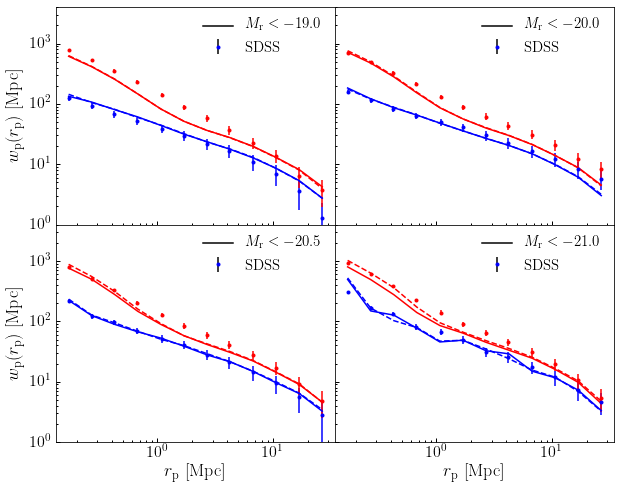

In [19]:
fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)  #  smash top and bottom plots
fig.subplots_adjust(wspace=0)  #  smash left and right plots

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()

__=ax1.errorbar(rp_zehavi, wp_blue19p0, np.sqrt(wperr_blue19p0), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax1.errorbar(rp_zehavi, wp_red19p0, np.sqrt(wperr_red19p0), 
                fmt='.', color='red')
__=ax1.plot(rp_mids, wp_v4_19p0_blue, color='blue', label=r'$M_{\rm r} < -19.0$')
__=ax1.plot(rp_mids, wp_v4_19p0_red, color='red')
__=ax1.plot(rp_mids, wp_v4b_19p0_blue, '--', color='blue')
__=ax1.plot(rp_mids, wp_v4b_19p0_red, '--', color='red')


__=ax2.errorbar(rp_zehavi, wp_blue20p0, np.sqrt(wperr_blue20p0), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax2.errorbar(rp_zehavi, wp_red20p0, np.sqrt(wperr_red20p0), 
                fmt='.', color='red')
__=ax2.plot(rp_mids, wp_v4_20p0_blue, color='blue', label=r'$M_{\rm r} < -20.0$')
__=ax2.plot(rp_mids, wp_v4_20p0_red, color='red')
__=ax2.plot(rp_mids, wp_v4b_20p0_blue, '--', color='blue')
__=ax2.plot(rp_mids, wp_v4b_20p0_red, '--', color='red')

__=ax3.errorbar(rp_zehavi, wp_blue20p5, np.sqrt(wperr_blue20p5), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax3.errorbar(rp_zehavi, wp_red20p5, np.sqrt(wperr_red20p5), 
                fmt='.', color='red')
__=ax3.plot(rp_mids, wp_v4_20p5_blue, color='blue', label=r'$M_{\rm r} < -20.5$')
__=ax3.plot(rp_mids, wp_v4_20p5_red, color='red')
__=ax3.plot(rp_mids, wp_v4b_20p5_blue, '--', color='blue')
__=ax3.plot(rp_mids, wp_v4b_20p5_red, '--', color='red')

# __=ax4.errorbar(rp_zehavi, wp_blue21p5, np.sqrt(wperr_blue21p5), 
#                 fmt='.', color='blue', label=r'${\rm SDSS}$')
# __=ax4.errorbar(rp_zehavi, wp_red21p5, np.sqrt(wperr_red21p5), 
#                 fmt='.', color='red')
# __=ax4.plot(rp_mids, wp_v4_21p5_blue, color='blue', label=r'$M_{\rm r} < -21.5$')
# __=ax4.plot(rp_mids, wp_v4_21p5_red, color='red')
# __=ax4.plot(rp_mids, wp_v4b_21p5_blue, '--', color='blue')
# __=ax4.plot(rp_mids, wp_v4b_21p5_red, '--', color='red')

__=ax4.errorbar(rp_zehavi, wp_blue21p0, np.sqrt(wperr_blue21p0), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax4.errorbar(rp_zehavi, wp_red21p0, np.sqrt(wperr_red21p0), 
                fmt='.', color='red')
__=ax4.plot(rp_mids, wp_v4_21p0_blue, color='blue', label=r'$M_{\rm r} < -21.0$')
__=ax4.plot(rp_mids, wp_v4_21p0_red, color='red')
__=ax4.plot(rp_mids, wp_v4b_21p0_blue, '--', color='blue')
__=ax4.plot(rp_mids, wp_v4b_21p0_red, '--', color='red')


xlabel3 = ax3.set_xlabel(r'${r_{\rm p}\ [{\rm Mpc}]}$')
xlabel4 = ax4.set_xlabel(r'${r_{\rm p}\ [{\rm Mpc}]}$')

ylabel1 = ax1.set_ylabel(r'$w_{\rm p}({r_{\rm p})\ [{\rm Mpc}]}$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}({r_{\rm p})\ [{\rm Mpc}]}$')

for ax in axes:
    leg = ax.legend()
    leg.legendHandles[0].set_color('k')
    leg.legendHandles[1].set_color('k')
    
ylim = ax1.set_ylim(1, 4000)


In [20]:
print(mock.keys())

['source_halo_id', 'target_halo_id', 'target_halo_x', 'target_halo_y', 'target_halo_z', 'target_halo_vx', 'target_halo_vy', 'target_halo_vz', 'target_halo_mass', 'host_halo_mvir', 'upid', 'mpeak', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sm', 'obs_sfr', 'sfr_percentile', 'um_mag_r_rest', 'um_gr_rest', 'um_ri_rest', 'is_on_red_sequence_gr', 'is_on_red_sequence_ri', 'x', 'vx', 'y', 'vy', 'z', 'vz', 'lightcone_id', 'redshift', 'um_mag_g_rest', 'new_mstar', 'new_um_mag_r_rest', 'new2_um_mag_r_rest', 'new_um_gr_rest', 'new_um_ri_rest', 'new2_um_gr_rest', 'new2_um_ri_rest']


In [21]:
mask = mock['new_um_mag_r_rest']<-21.5
# mask *= mock['is_on_red_sequence_gr'] ==  False
# np.count_nonzero(mask)

np.mean(mock['is_on_red_sequence_gr'][mask])

0.7680433752073951